## 2. Fasea: Algoritmoak diseinatzen

#### Paula Ontalvilla eta MIkel Zubillaga

Community Detection proiektuaren 1. fasea entregatu duzue, eta feedback-a jaso ere. Klasean hainbat algoritmo ikusi ditugu, batzuk soluzio bakarrean oinarritutakoak, beste batzuk aldiz, populazio bat erabiltzen dutenak. Horiez gain, hibridatzeko teknikak ere ikusi ditugu. Bigarrengo fase honetan, hiru algoritmo diseinatu beharko dituzue. Lehenengoa, algoritmo eraikitzaile bat izango da. Bigarrena, soluzio bakarrean oinarritutako heuristiko bat izan beharko du, eta azkenik, hirugarrena algoritmo poblazional bat izango da. Hiru algoritmoak estokastikoak izan beharko dute, eta horietatik, bik, oinarri probabilistikoa izan beharko dute. Adibidez, Simulated Annealing, Estimation of Distribution Algorithms (EDAk) edota Ant Colony Optimization (ACO) implementatu ditzazkezue. Proiektu honen kasuan, algoritmoen helburua, komunitate kopuru jakin bat emanik, modularitatea maximizatzen duen komunitate banaketa (soluzioa) bilatzen saiatzea da.

Errepasatu gaitegian zehar ikusi ditugun algoritmo guztiak, eta horiek kontuak izanik, libre zarete nahi dituzuen diseinuak sortzeko, baita ere hibridoak! Adi! Egiten duzuen aukeraketa argudiatu egin beharko duzue.

#### Entregablea

Bigarrengo fasea ebaluatu ahal izateko, notebook honetan bertan algoritmoen diseinua eta implementazioa proposatu beharko duzue. Gogoratu algoritmo bat azaltzeko modurik errezena fluxu diagrama eta sasikode bat egitea direla. Adi! Atal bakoitzean hartutako erabakiak eta garatutako metodoak egoki argudiatu beharko dituzue. Azalpenak ere nahi ditut. Diagramak ez dira eurak bakarrik azaltzen, beraz testutik erreferentziatu egin beharko dituzue. Saiatu idazkera zientifiko-tekniko batekin idazten (pentsatu publikatuko duzuen lan bat dela). Ez argudiatzeak edo lana garaiz ez entregatzeak penalizazioa jasoko dute ebaluagarria den proiektuaren zati honetan. eGelan zehazten dira notebook-a igotzeko <b>egun eta orduak</b>.

Momentuz, ez daukazue algoritmoen exekuzio eta konparaketak egin behar. Hirugarren fasean, esperimentazioaren inguruko baldintzak emango dizkizuet, eta, horrez gain, txostenaren idazketa burutu beharko duzue.

# Import-ak, aldagai eta funtzio orokorrak
Lehenik eta behin beharrezkoak diren  import-ak egingo ditugu:

Aurreko faseko 3 funtzio erabiliko ditugu:
* `sortu_grafoa`: Gure G grafoa sortzen du.
* `kalkulatuHasierakoMAT`: modularitatea kalkulatzeko beharrezkoak diren kalkuluak egin eta aldagaietan gordetzen ditu.
* `modularitatea2OPT`: modularitatea kalkulatzen du aurreko funtzioko aldagaiak hartuz. Aurreko fasean esan bezala, funtzio hau erabiltzea erabaki dugu eraginkorrenetako bat delako eta *community* moduluko emaitza berdinak lortzen dituelako. Funtzio hau erabiliko da helburu funtzioa kakulatzeko. Gure problemaren helburua modularitatea maximizatzea da. [Modularitatea sare baten propietate bat da eta sarea komunitatetan banatzeko proposamen konkretu bat da. Banaketa egokia izango da komunitateen barruan ertz asko badaude, eta komunitate artean gutxi.] *Hau borratu ingo nuke, teorian hoi ya azaldu deu 1. fasean*

In [3]:
from itertools import product
from ipynb.fs.defs.CDP_1_fasea_Ikasle import sortu_grafoa 
import community 
import networkx as nx
import numpy as np
import random as rm
import matplotlib.pyplot as plt
import seaborn as sns
import itertools 
import copy
import math
import networkx as nx
import numpy as np
import sqlite3
import pandas as pd
import itertools
import time
from pdb import set_trace
from collections import defaultdict

Autore kopurua grafoan: 1843
Elkarlan kopurua grafoan: 3211
Autore kopurua grafoan: 1843
Elkarlan kopurua grafoan: 3211
Autore kopurua grafoan: 1843
Elkarlan kopurua grafoan: 3211


In [4]:
def kalkulatuHasierakoMAT(G, weight='weight'):
    K = [[0 for i in range(len(G))]for j in range(len(G))]
    A = [[0 for i in range(len(G))]for j in range(len(G))]
    i = 0
    m = G.size(weight=weight)
    degree = {}
    for node in G:
        j = 0
        degree[node] = G.degree(node, weight=weight)
        for nbr, eattr in G[node].items():
            K[i][j] = G.degree(node, weight=weight)*G.degree(nbr, weight=weight)
            A[i][j] = eattr[weight]
            if i == j:
                A[i][j] *= 2
            j += 1
        i += 1
    K = np.array(K)/np.array(2*m)
    A = np.array(A)
    AK = (A-K)/np.array(2*m)
    
    return AK,m,degree

def modularitatea2OPT(G, partizioa, degree, m, weight='weight'):
    a = defaultdict(float)
    e = defaultdict(float)
    modularitatea = 0
    
    for node in G: #nodo bakoitzeko
        c = partizioa[node]
        a[c] += degree[node]
        for nbr, eattr in G[node].items(): #nbr = auzokide zehatza; eattr=nbr-ren datuak, adib pisuak
            if partizioa[nbr] == c:
                e[c]  += eattr[weight]
        
    for i in set(partizioa.values()):
        modularitatea += (e[i] / (2 * m)) - (a[i] / (2 * m)) ** 2
    
    return modularitatea    


Funtzio orokorrak definituko ditugu:

`partizioak_irudikatu(G,k, partizioa)`partizio bat eta partizio kopuru bat jasota, partizio bakoitza kolore desberdin batekin adieraziko du.

`from_dict_to_list(G, partizio)`Grafoa eta *dictionary* moduan adierazitako partizio bat emanda lista bat itzuliko du.

`bistaratu_grafoa(G)`grafoa emanda nodoak eta haien arteko ertzak inprimatzen ditu.

In [5]:
 def partizioak_irudikatu(G, k, partizioa):
    plt.figure(figsize=(13, 9))
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos, node_size = 20, node_color='0.75', label=True)
    nx.draw_networkx_edges(G, pos, alpha=0.5, width=1)

    number_of_colors = k
    i, color = 0, []
    while i < number_of_colors:
        color_aux =[rm.choice('0123456789ABCDEF') for j in range(6)]
        if color_aux not in color:
            color.append("#"+''.join(color_aux))
            i += 1
             
    #kolore desberdinak izan behar dira
    assert(len(np.unique(color)) == number_of_colors)

    # Draw a subgraph, reusing the same node positions
    for i in range(k):
        partizioa_elem = [k for k,v in partizioa.items() if v==i] #lortu i. partizioko elementuak
        nx.draw(G.subgraph(partizioa_elem),node_size = 20, pos=pos, node_color=color[i])

    plt.show()

    plt.axis('off')
    plt.show()

In [6]:
def from_dict_to_list(G, partizioa):
    solution = []
    for autore in G.nodes():
        solution.append(partizioa[autore])
    return solution
        

In [7]:
def bistaratu_grafoa(G):
    #Draw graph
    plt.figure(figsize=(13, 9))
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos, node_size = 20, node_color='0.75', label=True)
    nx.draw_networkx_edges(G, pos, alpha=0.5, width=1)
    plt.show()

    plt.axis('off')
    plt.show()

Aldagai orokorrak hasieratuko ditugu:  

Gure hasierako `G` grafoan, autore bakoitzeko nodo bat izango dugu, eta bi autoreren artean elkarlana egon bada (artikulu bat batera idatzi badute), orduan dagozkien nodoen artean arku bat egongo da. Baina ez da berdina elkarlan bat egitea, edo 100. Horregatik, arkuek pisu bat izango dute, elkarlan kopurua adieraziko duena.

In [8]:
G_ = sortu_grafoa()

Autore kopurua grafoan: 1843
Elkarlan kopurua grafoan: 3211


# Aurre-prozesaketa

Gure problemak daukan arazo nagusia grafoa tamaina da 1843 nodo eta 3211 arku ditu, hain zuzen ere. Honek asko zaildu egiten du soluzio bat aurkitzea. Izan ere, gure kodeketaren bilaketa espazio (???)!!! grafoan ditugun nodo bezain adinekoa da. Hortaz, bilaketa lokaletan sortuko den ingurunea oso handia da eta konputazio aldetik ezinezkoa adibidez, *swap* funtzioa erabiltzen baldin bada $\binom{1843}{2}$ kandidato desberdin sortu beharko lituzke ingurune funtzioak.  

Bestalde, gure grafoari erreparatzen baldin badiogu (1. irudia) ikus daiteke nola nodo asko ditugun gutxi batzuekin konektatuta edo bakarrik.  Hauek gure helburu funtzioan ez dute eragin handirik izango, hau da, ez dute modularitatea asko hobetuko zeren hauen arteko elkarlana oso handia ez da izango berain artean ertz gutxi baititugu. Nodo hauek gure problemari erredundantzia ematen diote, hauek partizio baten edo beste batean jartzeak ez baitu gure helburu funtzioa asko hobetzen.

Beraz, arazo honi aurre egiteko erabaki dugu preprozesaketa bat egitea. Nodo erredundate hauek kenduko ditugu honela gure problemaren nodo kopurua eta konputazio maila murrizteko. Gure problema orain izango da erdiko nodo horien partizio optimoa aurkitzea zeinak gure modularitatea hobetzen duen. Hori ebatzi ostean nodo erredundante horiek edozein partizioetan sartuko ditugu ez baitu gure optimoa nabarmen aldatuko.

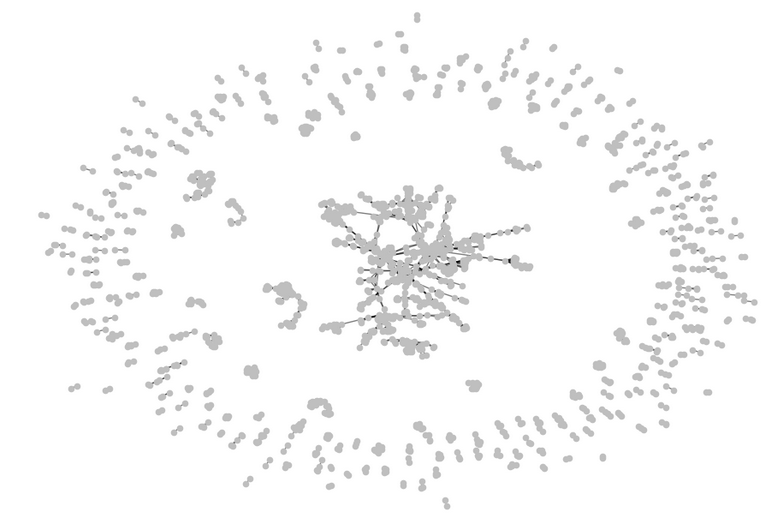
**1. irudia.** Gure problemaren grafoa

## Kodea


In [9]:
def sakonerako_korritzea(G, node, aurkitutakoak):
    aurkitutakoak[node] = True
    kont = 0
    for auz,_ in G[node].items():
        if not aurkitutakoak[auz]:
            aurkitutakoak[auz] = True
            kont += 1 + sakonerako_korritzea(G, auz, aurkitutakoak)
    return kont
        
def aurreprozesaketa(G):
    auzokideak = {}
    for node in G:
        aurkitutakoak = {}
        for node2 in G:
            aurkitutakoak[node2] = False
        auzokideak[node] = sakonerako_korritzea(G, node, aurkitutakoak)
    auzokideak = dict(sorted(auzokideak.items(), key=lambda x: x[1], reverse=True))
    return auzokideak

def grafo_aurreprozesaketa(auzokideak):
    # Datuak irakurri
    # Get data
    connect = sqlite3.connect('./nips-papers/database.sqlite')
    query = """
    SELECT pa.paper_id, pa.author_id, a.name
    FROM paper_authors AS pa JOIN papers AS p ON pa.paper_id = p.id
    JOIN authors as a ON pa.author_id = a.id
    WHERE p.Year BETWEEN '2014' AND '2015'
    """
    df = pd.read_sql(query, connect)

    # Have a look at data
    df.head(10)
    G_ = nx.Graph()

    # Transform
    # Autorearen IDa erabili beharrean erabili izena.
    for p, a in df.groupby('paper_id')['name']: 
        for u, v in itertools.combinations(a, 2):
            if u != v and auzokideak[u]>100 and auzokideak[v]>100:#ez badira nodo berdina
                if G_.has_edge(u, v):
                    G_[u][v]['weight'] +=1
                else:
                    G_.add_edge(u, v, weight=1)
    # Print graph size
    print('Autore kopurua grafoan:', G_.number_of_nodes())
    print('Elkarlan kopurua grafoan:', G_.number_of_edges())
    
    return G_

Orain gure sarrerako grafoaren aurre-prozesaketa bat egingo dugu eta hau bistaratuko dugu.

Autore kopurua grafoan: 531
Elkarlan kopurua grafoan: 1124


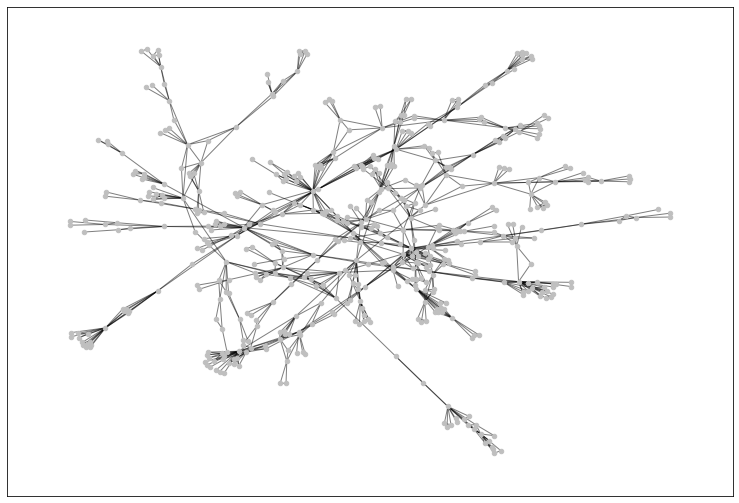

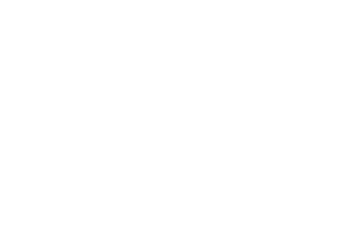

In [10]:
auzokideak = aurreprozesaketa(G_)
G = grafo_aurreprozesaketa(auzokideak)
bistaratu_grafoa(G)

Orain gure problemak 1843 nodo izatetik 531 nodo izatera pasa da. Aurre-prozesaketa honen bidez nodo kopurua erdi baino gutxiagora murriztu dugu. Goian ikus dezakegu gure grafo berria zein den, gure hasierako grafoko erdiko nodoak dira hain zuzen ere.   
Hemendik aurrera egingo ditugun kalkulu guztiak grafo horrekin egingo dira.

Jarraian definitzeko geratzen zaizkigun aldagai orokorrak ditugu. Aurre-prozesatutako grafoa `G`daukagula, elkarlan guztien batura adieraziko dugu `m` aldagaiaren bidez. Bestalde,`AK`eta `degree`aldagaiak modularitatea optimizatzeko aldagaiak dira. Hauek zehazki grafoan dauden nodoen gradua eta  $\left[A_{vw}-\frac{k_vk_w}{2m}\right]$ eragiketaren emaitzak gordetzen ditu. Modu honetan informazio hau kalkuluak egiterakoan ez da kalkulatu behar baizik eta zuzenean atzitu daiteke.

In [11]:
m = G.size(weight='weight')
AK,m,degree = kalkulatuHasierakoMAT(G)

# Random Search

Hasteko, *random search* inplementatuko dugu baseline edo oinarri-lerro moduan erabiltzeko. Horrela, inplementatzen ditugun beste algoritmoekin lortzen ditugun soluzioekin konpara ditzakegu. Badakigu gure algotimoetan lortzen ditugun soluzioak *random search*-ek itzultzen diguna berdinak edo hobeak izan behar direla.

In [160]:
def random_search(G, num_solutions):
    size = len(G)
    maxim = -float('inf')
    best_solution = []
    for i in range(num_solutions):
        k = rm.randint(0,size-1)
        sol = [i for i in range(k)] + [rm.randint(0,k) for i in range(size-k)]
        partition = dict(zip(G.nodes, sol))
        fitness = modularitatea2OPT(G, partition, degree, m)
        if (fitness > maxim):
            maxim = fitness
            best_solution = sol

    return maxim,best_solution


In [161]:
k = 200
fitness, solution = random_search(G,k)
partition = dict(zip(G.nodes, solution))
#modularitatea kalkulatuko dugu
print("Soluzioaren modularitatea: ", str(fitness))

Soluzioaren modularitatea:  0.006718793677866921


*Random Search*-ek 200 soluzio desberdinekin probatuz lortzen duen modularitaterik onena 0.004850411646885709 da. Beraz, hemendik aurrera inplementatzen ditugun algoritmoek soluzio hau baino hobea edo berdina den soluzio bat eman behar digute ondo inplementatua baldin badaude.  

Gure algortimoen soluzioa konparatzeko soluzio bat daukagula has gaitezke eskatzen diren hiru algoritmo desberdinak inplementatzen.

# Algoritmo eraikitzailea

Algoritmo eraikitzaileak soluzio huts batetik hasten dira eta iteratiboki, elementuak gehitu ohi dira soluzioan. Soluzioan egoteko irizpide bat maximizatuko duen elementua aukeratzen da. Gure problemarako maximizatu nahi den soluzioa modularitatea da.

Inplementatutako algoritmoak hurrengoa egiten du:
1. `k`aldagai bat jasotzen du zeinak esaten dion zenbat partizio egin behar diren. Aurre-preprozesaketa egin denez nodo guztiek garrantzia berdina dute grafo berrian nodoen artean ertz gehien dituzten nodoak ditugulako. Beraz, *k* autore aukeratzen dira ausaz eta *k* autore bakoitza partizio bat osatuko du.

2. Partizio bakoitzean autore berri bat sartzen da iteratiboki.  Nodo bat hartzen baldin bada ze partizioan jartzearen erabakia ez da tribiala horrek eragin handia izango baitu modularitatean beraz, kontu handiz egin behar den zeozer da. Lehenik eta behin partizioan sartzen diren nodo (autore) berriak partizioko beste autoreekin konektatuta daude. Honela, modularitatea maximizatuko da partizioan sartzen ditugun nodoak konektatuta daudelako, hau da, nodo hauek berain artean elkarlan maila bat dute. Hortaz, partizio bakoitzean dauden nodo bakoitzaren auzokideak aztertu egiten dira eta sartu egiten da modularitatea gehien maximizatzen duen autorea. Zehazki, hurrengo kalkulua maximizatzen duena:  $\left[A_{vw}-\frac{k_vk_w}{2m}\right]$ 

3. Partizio bakoitzean dauden nodoen auzokide guztiak aztertu eta dagokion partizion sartu direnean gainerako autoreak partizio bakoitzean sartzen dira iteraboki. Sartzeke geratzen diren autoreak sartuko dira partizioetan non hor dauden nodoekin erlaziorik ez duten, hau da, ez daude konektatuta, ez dute elkarlanik. Nahiz eta elkarlanik ez izan nodo hauek ez dira ausaz partizio batean sartuko, nodo bakoitza gradu bat daukalako eta hau baita erabiltzen delako modularitatea kalkulatzean. Hortaz, sartzeke geratzen diren autore bakoitza modularitatea gehien handitzen duen partizioan sartzen da iteratiboki. Zehazki, hurrengo kalkulua maximizatzen duen partizioan:  $\left[A_{vw}-\frac{k_vk_w}{2m}\right]$, $A_{vw} = 0$ izango da ertzik ez dagoelako.

## Sasikodea

**Sarrera:**
* $k$ : egingo diren partizio kopurua
* $G$ : grafo bat non nodo bakoitza idazle bat izango da eta ertzak idazleak lotzen dituen haien arteko elkarlana adieraziz

**Irteera:** $C$ : modularitatea maximizatzen duen partizioa

**Hasieraketa:**
> $C = \{ C_{1},...,C_{k}\}$
>
**Algoritmoa:**
> eguneratu = True 
>
> **while** eguneratu:
>>
>> **for** i in range(k)
>>>  v = Q maximizatzen duen nodoa
>>>
>>> **if** v == None:
>>>
>>>> eguneratu = False  
>>>
>>> **else:**
>>>
>>>> $C_{i} ← C_{i} ∪ {v}  $  
>>>>
>>>> $V ← V \backslash \{v \}$
>
> **while** V $\neq \emptyset$:
>>**for** i in range(k):
>>
>>> v = Q maximizatzen duen nodoa
>>>
>> $C_{i} ← C_{i} ∪ {v}  $  
>>
>> $V ← V \backslash \{v \}$
>>
> **return** C


## Kodea

In [162]:
def aukeratu_onena(G, partizioa_elem, aztertuak, weight):
    maxim, elem_max = -float('inf'), None
    for elem in partizioa_elem:
        kv = G.degree(elem, weight=weight)
        for nbr, eattr in G[elem].items(): #nbr = auzokide zehatza; eattr=nbr-ren datuak, adib pisuak
            if nbr not in aztertuak: #ez baldin bada aztertua izan
                wt = eattr[weight] #n eta nbr arteko pisuak
                kw = G.degree(nbr, weight=weight)
                batu = wt - (kv * kw)/(2*m)
                if batu > maxim:
                    maxim = batu
                    elem_max = nbr
    return elem_max

def partizio_partziala(G, k, partizioa,weight, aztertutakoak):
    eguneratu = True
    while eguneratu: 
        for i in range(k): #partizio bakoitzeko
            partizioa_elem = [k for k,v in partizioa.items() if v==i] #lortu i. partizioko elementuak
            elem_onena = aukeratu_onena(G, partizioa_elem, aztertutakoak, weight)
            if elem_onena == None:
                eguneratu = False
            else:
                eguneratu = True
                aztertutakoak.append(elem_onena)
                partizioa[elem_onena] = i
    return partizioa, aztertutakoak

def partizio_onenean_sartu(G, k, partizioa, weight, node):
    maxim, partizio_onena, elem_max = -float('inf'), None, None
    for i in range(k): #partizio bakoitzeko
        batu = 0
        partizioa_elem = [k for k,v in partizioa.items() if v==i] #lortu i. partizioko elementuak        
        for elem in partizioa_elem:
            kv = G.degree(elem, weight=weight)
            kw = G.degree(node, weight=weight)
            batu += - (kv * kw)/(2*m) #Avw = 0 izango da ez daudelako konketatuta
        if batu > maxim:
            maxim = batu
            partizio_onena = i
    partizioa[node] = partizio_onena #sartu 
    return partizioa
    
#partizio bakoitzean egongo diren idazleak ausaz aukeratuko dira
def algoritmo_eraikitzailea(G, k, weight= 'weight'):
    hasi_elem =  rm.sample([node for node in G], k) #aukeratu k ausaz #hasieraketa(G,k)
    aztertutakoak =[] 
    partizioa = {}
    kont = 0
    eguneratu = True
    for elem in hasi_elem: #sartu elementu bakoitza partizio batean
        aztertutakoak.append(elem)
        partizioa[elem] = kont
        kont += 1
    #sortutako lehenengo partizioa aukeratutako elementuekin. Partizioetan dauden elementuak konektata daude
    lehenengo_partizioa, aztertutakoak = partizio_partziala(G, k, partizioa, weight, aztertutakoak)
    #partizioen barruko elementuekin konektatu gabeko elementuak gehitu behar ditugu    
    for node in G:
        if node not in aztertutakoak: #ez baldin bada aztertu
            partizioa = partizio_onenean_sartu(G, k, partizioa, weight, node)
            aztertutakoak.append(node)
    
    return partizioa

500 nodo inguru izanda probatuko dugu partizio kopurua 20 ezarriz eta modularitatea kalkulatuko dugu.

In [163]:
k = 20
partizioa = algoritmo_eraikitzailea(G,k, weight= 'weight')
#modularitatea kalkulatuko dugu
print("Soluzioaren modularitatea: ", modularitatea2OPT(G,partizioa, degree, m))

Soluzioaren modularitatea:  0.7976086821031897


Ikus daitekenez lortu dugun modularitatea *Random Search* bidez lortutako baino handiagoa da. Seinale ona da hori. Orain lortutako partizioa irudikatuko dugu partizio bakoitza kolore batez margotua dagoelarik.

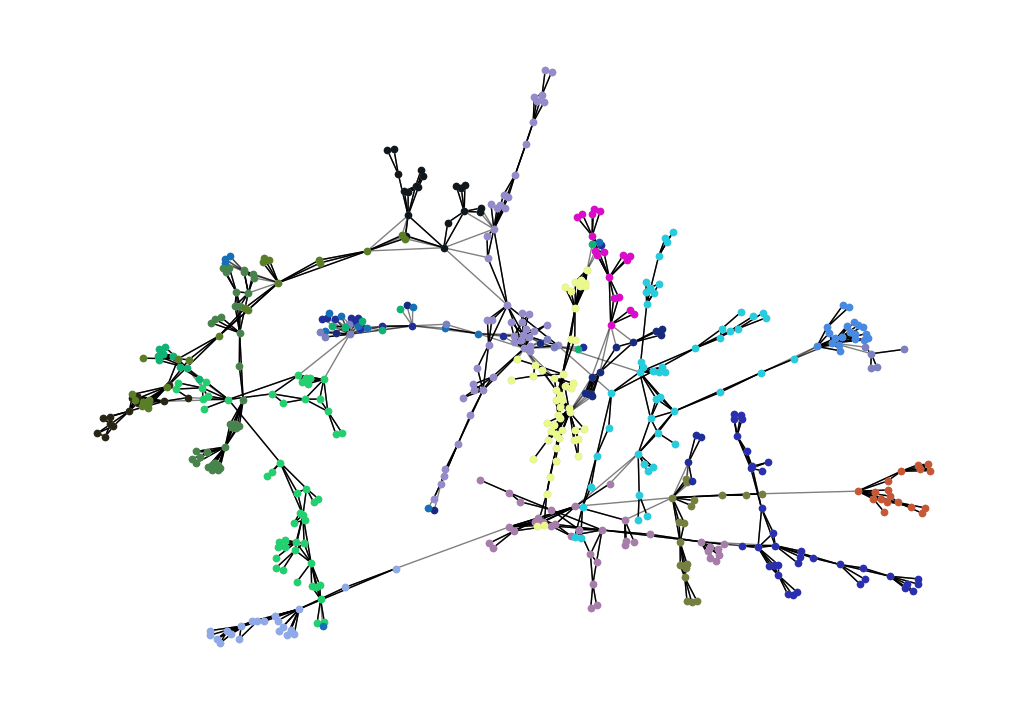

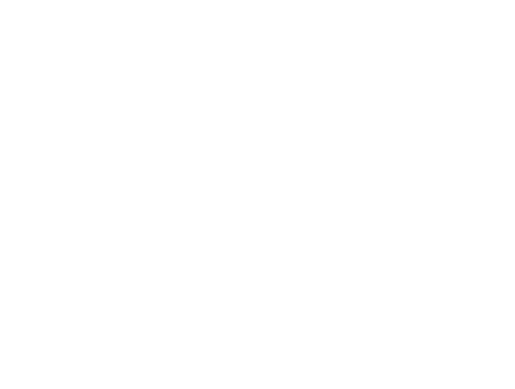

In [164]:
partizioak_irudikatu(G, k , partizioa)

# Soluzio bakarrean oinarritutako heuristikoak: ILS

Soluzio bakarrean aukeratutako heuristiko moduan ILS aukeratu dugu. Hasiera batean *simulated anneling* algoritmoa erabilitzea pentsatu dugu baina honek parametro eta bariazio asko dituenez baztertu egin dugu. ILSk uneko optimo lokala hartuko du oinarritzat eta optimo lokal batean trabatuta geratzen denean, uneko soluzioa *perturbatu* egiten du eta bertatik bilatzen jarraitzen du. Optimo lokal berri batera heltzen garenean, soluzio hori onartuko dugunetz erabaki behar da. [1] Hurrengo argazkian, ikus 1.irudia, ILS algoritmoaren ideia azaltzen da.

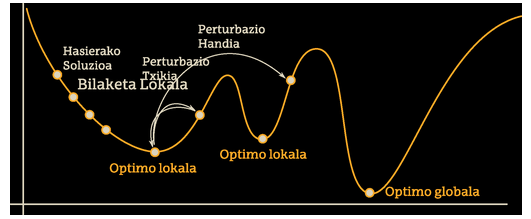
**1.irudia.** ILS algoritmoaren ideia.

Algoritmoa zehazteko bi prozedura berri zehaztu behar dira: *perturbazioa* eta *onartze irizpidea*.

* **Perturbazioa:** Hasteko, optimo lokal batean trabtuta geratzen denean, hura nola perturnatu pentsatu behar da. Soluzio bateko inguruneko soluzioak antzekoak direnez aldaketa handiak sartu behar dira  optimo lokalatik eskapatzeko. 1. irudian ikus daiteke nola perturbazioaren tamaina garrantzia handia duela. Izan ere, oso handia baldin bada optimo globalatik pasa gaitezke eta beste optimo lokalean trabatuta gelditu. Aurrerago azaldu egingo da ze perturbazio mota eta gradu erabiliko den.

* **Onartze iripidea:** Uneko optimo lokala perturbatu ondoren bilkaeta lokala aplikatzen da eta erabaki behar da lorrutako optimo berria edo berriro optimo zaharra perturbatuko den. Aurrerago azalduko da problema honetarako erabili den onartze irizpidea.

## ILS-ren sasikodea
**Sarrera:** $G$ : grafo bat non nodo bakoitza idazle bat izango da eta ertzak idazleak lotzen dituen haien arteko elkarlana adieraziz

**Irteera:** $s_{best}$: modularitatea maximizatzen duen soluzioa

**Algoritmoa:**
> $ s^0$= Generate initial solution() 
>
> $s^* = local\_search(s^0)$  
>
> $s_{best} = s^*$  
>
> 1: **repeat**  
>
> 2: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $s^´$ =  perturbation$(s^*)$
>
> 3: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $s^*´$ = local\_search$(s^´)$
>
> 4: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $s^*$ = simmulated\_annealing$(s^*´, s^*)$
>
> 5: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **if** $Q(s^*)$ > Q($s_{best}$) **then**
>
> 6: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$s_{best} = s^* $  
>
> 7: **until** $!stop\_criterion()$

## Erreferentziak
1. fdsgf
2. Liu, C., Kang, Q., Kong, H., Li, W., & Kang, Y. (2020). An iterated local search algorithm for community detection in complex networks. International Journal of Modern Physics B, 34(04), 2050013.

## Hasieraketa
Gure hasierako partizioa hasieratzeko era desberdinak ikusi ditugu. Horietako bat *greedy constructive heuristic* (GCH) Sanchez et al proposatutako. Horren sasikodea 2. irudian ikus daiteke. GCHk, lehenik, V erpin multzotik v nodo bat aukeratzen du ausaz. Ondoren, V nodoa jasotzen duen kluster bat gehitzen zaie eraikuntzarako *s* soluzioari. Jarraizteko, hurrengo nodoa ausaz aukeratzen da eta GCHk ebaluatzen du nolako modularitatea dagoen nodoa $C_{i}$ kluster bakoitzean sartzean. Orduan, emaitzarik onena duen modularitea soluzioen egungo modularitatea baino handiagoa bada, nodoa dagokion $C_{i}$  klusterrean sartuko da. Bestela, V nodoa duen multzo berri bat sartzen da s soluzioan. Azkenik, hautatutako nodoa V multzotik kentzen da. Prozesua errepikatzen da V multzoa hutsik egon arte.


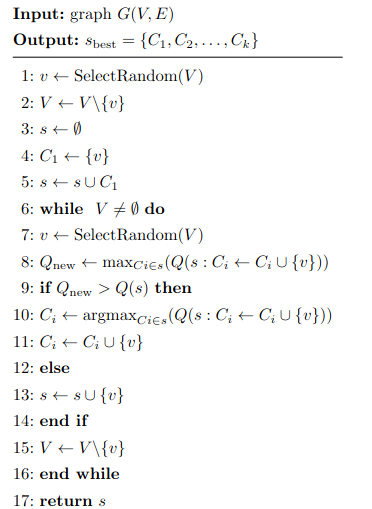
**2. irudia** GCH algoritmoaren sasikodea

### Kodea

In [167]:
def hasieratu(G):
    nodoak = list(G.nodes())
    node = rm.choice(nodoak)
    i = 1
    nodoak.remove(node)
    partizioa = {}
    for n in nodoak:
        partizioa[n] = 0

    partizioa[node] = i
    Q = modularitatea2OPT(G, partizioa, degree, m)
    while nodoak!= []:
        hobetu = False
        node = rm.choice(nodoak)
        for j in range(i):
            partizioa[node] = j
            Q1 = modularitatea2OPT(G, partizioa, degree, m)
            if Q1 > Q:
                hobetu = True
                break
        if not hobetu:
            i += 1
            partizioa[node] = i
        nodoak.remove(node)
        Q = modularitatea2OPT(G, partizioa, degree, m)
    return partizioa

Soluzioaren modularitatea:  0.2175656837983153
Partizio kopurua: 144


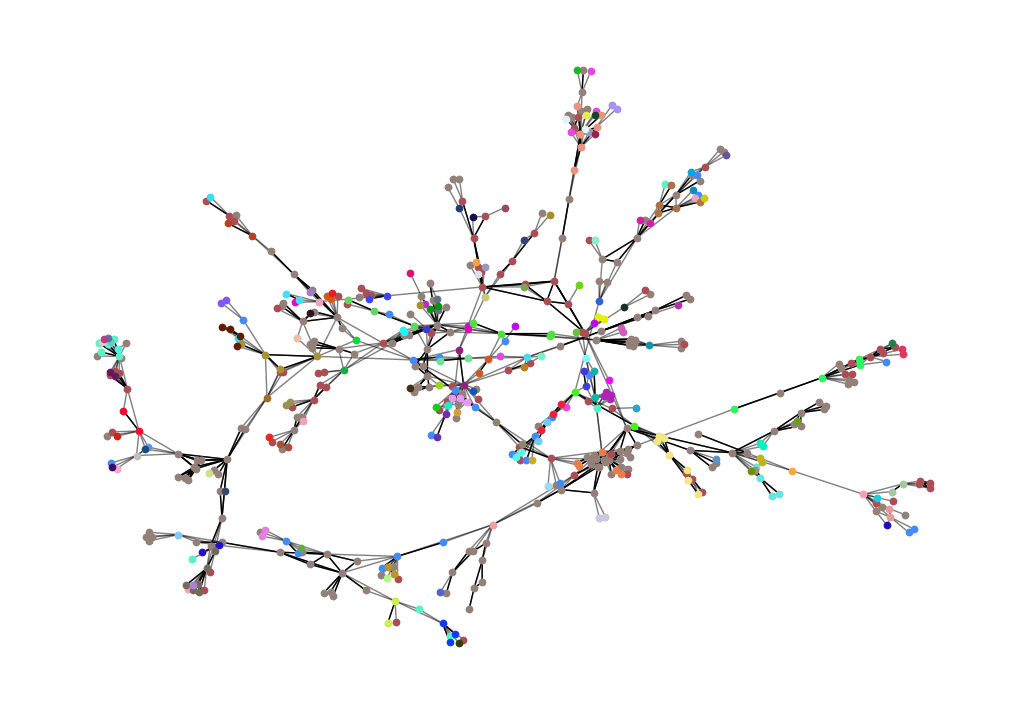

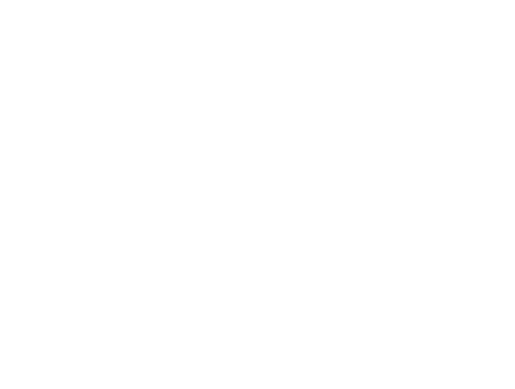

In [178]:
partizioaILS = hasieratu(G)
print("Soluzioaren modularitatea: ", modularitatea2OPT(G,partizioaILS, degree, m))
kILS = len(np.unique(list(partizioaILS.values())))
print("Partizio kopurua: "+ str(k))
partizioak_irudikatu(G, k , partizioaILS)

Funtzio honek itzultzen digun modularitateak algoritmo eraikitzailea itzultzen diguna baina txarragoa da. Honek zentzua dauka zeren soluzioa eraikitzen denean nodoak ausaz hartzen dira eta bere auzokideak aztertuta ez egotea gerta daiteke. Beraz, komunitate berri batean sartzen da. Auzokideak hartzen ez direnez askotan ematen den egoera da nodo bat aukeratzea eta beraren auzokideak partizio desberdinetan egotea nodo horiek lotzen dituen nodoa oraindik ez delako aukeratu. Nodo hori hasiera batean aukeratuta egon balitz bere auzokide guztiak baita komunitate berdinean egongo lirateke edo behintzat batzuk. Horregatik komunitate asko sortzen dira. Goiko grafoan ikus daiteke nola komunitate txiki asko dauden eta nola nodo asko ditugun bere auzokide guztiak komunitate desberdinetan daudela.  

Hala ere, ez da funtzio hau erabiliko ILSen sarrera moduan. Izan ere, Ingurune funtzioa *hamming* izanda ingurunea ahalik eta txikien izateko komunitate kopurua txikia izatea komeni delako eta azaldutako funtzioak komunitate asko sortzen ditu. Horren ordez, algoritmo eraikitzaileak sortzen duen soluzioa erabiliko da hasierako soluzio moduan. Alde batetik, komunitate kopuru bat zehaztu ahal duzulako kopuru txiki bat ezartzeko aukera emanez. Beste alde batetik, soluzio nahiko onak itzultzen duelako kasu askotan 0.3 baino altuagoak. Aurreko fasean aipatu bezala 0,3 baino altuagoko balioak sarearen komunitate estruktura ona denaren adierazgarri dira.

## Local Search

Ingurune funtzioa sortzeko *hamming* erabiliko dugu. Hamming ingurune funtzioak nodo baten komunitatea aldatzen du. Funtzio hau erabiltzea erabaki dugu honek, *swap* eta *insert* ingurune funtzioak ez bezala, konbexua delako. Hau da, gure soluzioak 6 zenbakia duen komunitatea ez badu hamming-ek komunitate hau duten kandidatoak baita sortuko ditu. Honek soluzio posible guztiak sortzen ditu. Horregatik honek sortzen duen ingurunea handiagoa da.  

Inguruneko kandidatoak aukeratzeko *best first* estrategia erabiltzea erabaki dugu. Honek modularitatea hobetzen duen inguruneko lehenengo kandidatoa itzultzen du. Estrategia honen kostu konputazionala *greedy* baino baxuagoa da bakarrik kasu txarrean inguruneko kandidato guztiak aztertzen dituelako. *Greedy*k aldiz, beti inguruneko kandidato guztiak aztertzen ditu.

### Sasikodea

**Sarrera:** $f$ helburu-funtzioa, $s_0$ hasierako soluzioa eta $N$ ingurune funtzioa
 
**Irteera:** $s^*$ soluzio optimoa

**Algoritmoa:**
>
> 1: $s^* = s_0$
> 
> 2: **repeat**
> 
> 3: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $H = \{s^´ \in N(s^*) | f(s^´) > f(s^*)\}$
>
> 4: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **if** $|H|>0$ **then**
>
> 5: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Aukeratu $H$-n dagoen lehenengo soluzioa $s^´$
>
> 6: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $s^* = s^´$
>
> 7: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **end**
>
> 8: **until** $s^*$ aldatu da edo iterazio kopuru maximora ailegatu

### Kodea

In [217]:
def aldatuKomunitatea(solution, i, j):
    solution[i] = j
    return solution
    
def local_search_hamming_ing(G, k, best_solution, best_fitness, max_evals):
    size = len(best_solution)
    aldatu = True  
    for i in range(size):
        for j in range(k):
            if best_solution[i] != j: #komunitate desberdina
                sol_lag = aldatuKomunitatea(copy.deepcopy(best_solution), i, j)
                partition_lag = dict(zip(G.nodes, sol_lag))
                fit_lag = modularitatea2OPT(G, partition_lag, degree, m)
                max_evals -= 1
                if fit_lag > best_fitness:
                    aldatu = True
                    max_evals -= 1
                    return sol_lag, fit_lag, max_evals, aldatu
                if max_evals <= 0:
                    return best_solution, best_fitness, max_evals, aldatu
 
    return best_solution, best_fitness, max_evals, aldatu

def local_search(G, k, best_solution, max_evals):
    best_partition = dict(zip(G.nodes, best_solution))
    best_fitness = modularitatea2OPT(G, best_partition, degree, m)
    aldatu = True
    while max_evals >= 0 and aldatu:
        best_solution, best_fitness, max_evals, aldatu = local_search_hamming_ing(G, k, best_solution, best_fitness, max_evals)
    return best_solution, best_fitness, max_evals
        

## Perturbatu

ILS-ek optimo lokaletatik ihes egiten du eta eskualde berriak esploratzen ditu LSen bidez sortu diren soluzioei perturbazioak aplikatuz. Perturbazioaren gradua txikiegia bada LSak berriz optimoa lokalera ailegatuko da. Oso handia bada aldiz, ILS algoritmoa zorizko hasieraketa anizkoitzeko  algoritmoa bilakatuko da. Beraz, oso garrantzitsua da parametro hau zehaztea. Horretarako algoritmoak bi metodoen artean aukeratzen ditu probabilitate batekin: `mugitu()`eta `banatu()`.

### `Mugitu()`
Honek *boundary* nodoak bere auzokideen komunitate batera mugitzen ditu. *Boundary* nodo bat izango dugu baldin eta nodo horren auzokide guztiak komunitate berdinean ez badaude. Bestalde, perturbatzen dugun bakoitzean *boundary* nodo kopuru finko bat komunitatez aldatuko ditugu: ditugun nodo guztien $\beta$ portzentaia. $\beta$ parametro hau 0.3 izatea erabaki dugu irakurri dugulako hobekien funtzionatzen duen balioa dela. [2]  

Hurrengo argazkian (ikus 3.irudia), funtzioaren adibide bat daukagu. Zehazki, {3, 7, 9} multzoko nodoak auzokideko komunitatea esleitzen zaie.

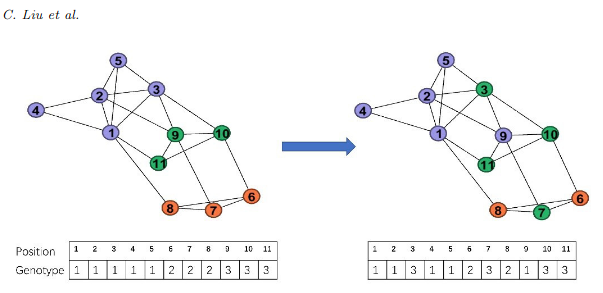
**3.irudia**. Mugitu() funtzioaren adibide bat.


### `Banatu()`
Gure probleman komunitate kopurua zehaztuta ematen diguten zerbait da. Beraz, funtzio honek komunitate kopuru desberdinak aztertzen ditu. Funtzioak gure soluzioko $\gamma$ komunitate kopurua hartzen ditu ausaz. Ondoren, $\gamma$ komunitate barruan dauden nodo guztiak komunitate bihurtzen ditu non, komunitate bakoitza nodo bakar batez osatuta egongo den. $\gamma$ parametroak perturbazioaren indarra adierazten digu. Erabaki dugu, irakurritakoan arabera, honen balioa 1-ekin hasieratzea eta handituz joango gara balioari 1 gehituz iterazio horretan lortzen den optimoa onartze irizpideak onartzen ez badu. Bestela, $\gamma$ 1ekin hasieratuko da berriz. $\gamma$-k hartu dezakeen balio altuena 0.6 * |s| (soluzioan ditugun komunitate kopurua) izango da komunitate gehiegi ez sortzeko.  

Hurrengo argazkian (ikus 4.irudia), funtzioaren adibide bat daukagu. Zehazki, {9, 10, 11} multzoko nodoak komunitate bat osatzen dute eta nodo bakoitza komunitate berri bat sortzen du.

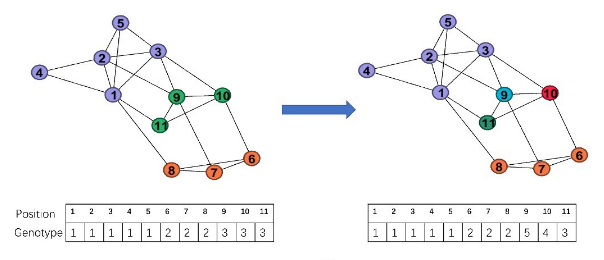
**4.irudia**. Banatu() funtzioaren adibide bat.

### Sasikodea
**Sarrera:**
* $G$ : grafo bat non nodo bakoitza idazle bat izango da eta ertzak idazleak lotzen dituen haien arteko elkarlana adieraziz
* $s$ : momentu arte soluziorik onena, non adierazita dago nodo bakoitza ze partizioan dagoen

**Irteera:** $s$: soluzioa perturbatuta

**Algoritmoa:**
>1: Ausaz k zenbaki bat aukeratu 1 eta 2 artean
>
>2: **switch**(k)
>
>3: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **case 1:** s ← Mugitu(G(V, E), s)
>
>4: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **case 2:** s ← Banatu(G(V, E), γ, s)
>
>5: **end switch**
>
>6: **return** s

### Kodea

In [218]:
def mugitu(G, best_partition, best_solution, beta = 0.3):
    k = int(len(G.nodes())*beta) #perturbatuko diren nodo kopurua
    
    while k >= 0:
        for node in G:
            boundary= False
            auzokideak = list(G[node].keys())
            for a in auzokideak:
                if best_partition[a] != best_partition[node]:
                    boundary = True
                    best_solution = swapPositions(best_solution, best_partition[a], best_partition[node])
                    k -= 1
                    if k <= 0:
                        return best_solution
                    break
    return best_solution


In [219]:
def banatu(G, best_partition, best_solution, gamma):
    k_max =  max(list(best_partition.values()))
    assert(gamma <= 0.6*k_max)
    
    komunitateak = rm.sample(list(np.unique(best_solution)), gamma)
    lag = copy.deepcopy(best_solution)
    inkr = 1
    
    for sol in best_solution:
        if sol in komunitateak:
            lag[sol] = k_max + inkr
            inkr +=1
    return lag
    

In [220]:
def pertubatu(G, best_solution, best_partition, gamma):
    k = rm.randint(1,2)
    if k == 1:
        solution = mugitu(G, best_partition, best_solution)
    else:
        solution = banatu(G, best_partition, best_solution, gamma)
    return solution

## Onartzeko irizpidea: Simulated Anneling

Onarpen-irizpideak hurrengo iterazioan, sortutako soluzioa abipuntutzat hartuko denetz zehazten du. Muturreko bi estrategia plantea daitezke: soluzioa beti onartzea eta modu honetan dibertsifikazioa suspertu edo soilik uneko baino hobea denean onartu. Estrategi hauek ez dira oso egokiak, horregaitik soluzioak probabilitate batekin onartuko ditugu. Zehazki, *simulated anneling*-en onarpen irizpidea erabiliko dugu.  

*Simulated anneling*-ek iterazioan sortutako s^*' soluzioa onartuko du bere modularitatea momentuko s^*-ko baino hobea baldin bada. Bestela, probabilitate batekin onartuko da: $ exp(\frac{modularity(s∗′) − modularity(s∗)}{T})$ non, T tenperatura izeneko parametro bat den. Irakurritakoaren arabera, $T_{init}$ = 0.025 x modularity(s∗) izango da modu horretan s* baino %2.5 okerrago den soluzio bat onartukp da 1/e propbabilitaterekin. Tenperatura iterazio bakoitzean txikituz joango da *cool* parametro baten bidez. Erabaki da, berriz ere irakurritakoaren arabera, 0.9 izatea eta era geometriko batean tenperatura hoztea modu horretan, ez delako oso azkar txikituko tenperatura.

### Sasikodea
**Sarrera:** uneko soluziorik onena s* eta iterazio horretan lortutako soluziorik onena s*'
 
**Irteera:** hurrengo iterazioko s*

**Algoritmoa:**
> 1: **if** Q($s^∗′) ≥ Q(^∗)$ **then**
>
> 2: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $s^∗ ← s^∗′$
>
> 3: **else**
>
>4: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; p ← rand(0, 1)
>
>5: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **if** p ≤ exp (modularity$(s^∗′)$ − modularity$(s^∗$)/T **do**
>
>6: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $s^∗ ← s^∗′$
>
>7: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **end if**
>
>8: **end if**
>
>9: T ← 0.9 × T

### Kodea

In [221]:
def hasieratu_tenperatu(tenp_degree, best_fitness):
    return tenp_degree * best_fitness

In [222]:
def simulated_anneling(G, best_solution, best_partition, best_fitness, sol_lag, fit_lag, tenp_degree, cool, T, gamma):    
    gamma_ = 1
    
    if fit_lag > best_fitness:
        best_solution = sol_lag
        best_fitness = fit_lag

    else:
        tenp_aldaketa = fit_lag - best_fitness
        zbk = rm.uniform(0, 1)
        prob = math.exp((tenp_aldaketa/T))

        if zbk < prob: #onartuko dugu
            best_solution = sol_lag
            best_fitness = fit_lag
        else: 
            gamma_ = gamma + 1
  
    T *= cool
    gamma = gamma_
    
    return T, gamma, best_solution, best_fitness


## Iterated Local Search

Aurretik aipatuta sasikode aplikatuko dugu orain.



### Kodea


In [227]:
def ILS(G, best_solution, k, max_evals, tenp_degree=0.00025, cool=0.9):  
    best_partition = dict(zip(G.nodes, best_solution))
    best_fitness = modularitatea2OPT(G, best_partition, degree, m)
    print("Hasierako modularitate:" + str(best_fitness))
    best_fitness_ = best_fitness
    best_solution_ = best_solution
    T = hasieratu_tenperatu(tenp_degree, best_fitness)
    gamma = 1
    while max_evals >= 0:
        solution = pertubatu(G, best_solution, best_partition, gamma)
        solution, fitness, max_evals = local_search(G, k, solution, max_evals)
        T, gamma, best_solution, best_fitness = simulated_anneling(G, best_solution, best_partition, best_fitness, solution, fitness, tenp_degree, cool, T, gamma)
        if best_fitness > best_fitness_:
            best_fitness_ = best_fitness
            best_solution_ = best_solution
    return (best_fitness_, best_solution_, max_evals)



In [228]:
k = 20
partizioa = algoritmo_eraikitzailea(G,k, weight= 'weight')
initial_sol = from_dict_to_list(G, partizioa)
best_fitness, best_solution, evals = ILS(G,initial_sol, k, 100000)
print("Amaierako modularitatea: " + str(best_fitness))


Hasierako modularitate:0.4502816672827206
Amaierako modularitatea: 0.5140259754685044


In [230]:
k = 20
partizioa = algoritmo_eraikitzailea(G,k, weight= 'weight')
initial_sol = from_dict_to_list(G, partizioa)
best_fitness, best_solution, evals = ILS(G,initial_sol, k, 1000000)
print("Amaierako modularitatea: " + str(best_fitness))

Hasierako modularitate:0.5925466313777785
Amaierako modularitatea: 0.7714650586320885


# EDA
Soluzio hobetzeko probekin jarraiuz EDA motako algoritmo bat inplementatu dugu, gure kasuan UMDA aldaera erabili dugu. EDA motako algoritmoak populazioetan oinarritzen dira, populazioko indibiduo bakoitza soluzio (partizio) posible bat izanik. Populazioan indibiduoak aldatzen joango dira, probabilitate matrizea erabiliz. Probabilitate matrizeak n soluzio honenen gen bakoitzaren balioaren probabilitatea jasotzen du; ondoren, probabilitate horiekin, soluzio berriak lagintzen dira.
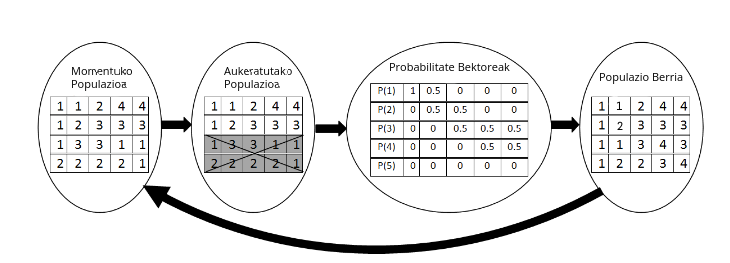
Zehazki gure UMDA algoritmoak ondorengoa egingo du:
1. Populazioa hasieratu ausazko soluzio batzuk sortuz
2. Aukeratu (tournament selection erabiliz) n soluzio populaziotik
3. Aukeratutako soluzioekin probabilitate matrizea sortu 
4. Probabilitate bektorea erabiliz soluzio berriak lagindu
5. Soluzio berriak mutatu probabilitate batekin
6. Soluzio berriak populaziora sartu, populazioko indibiduo txarrenak (modularitate baxuena dutenak) ezabatuz.
7. 2 pausura bueltatu edo g iterazioetan soluzioa ez bada hobetu amaitu.



## Tournament Selection

Tournament Selection erabilitako aukeratze irizpidea da. Aukeraketa mota honetan, helburu-funtzioak emandako balioaren arabera ordenatzen dira soluzioak. Ordenatu ondoren, aukeratze probabilitate bat ematen zaio elementu bakoitzari. Horrela, lehenengoa aukeratzeko Pt probabilitatea egongo da, bigarrena aukeratzeko (1-Pt)* Pt, hirugarrena aukeratzeko (1-Pt)^2 * Pt etab. Hau n aldiz egingo da, kontuan izanik behin soluzio bat aukera denean, ezingo dela berriro ere aukeratu. Modu honetara n elementu ezberdin aukeratu nahi dira probabilitate bektorea sortzeko.   

## Probabilitate Bektoreak

Probabilitate bektore bat egongo da kluster bakoitzeko. Hauetako dimentsio bakoitzak nodo zehatz bat kluster horretan egoteko probabilitatea jasotzen ditu. Probabilitate hau kalkulatzeko aukeratutako soluzioen nodo bakoitzean dauden balioak aztertzen dira; berdinak diren balioak kontatuz eta kopuru osoarekin zatituz, probabilitateak lortzen dira. 

## Mutatu

Nahiz eta EDA algoritmoek orokorrean ez dituzteten mutazioak erabiltzen gure algoritmoan erabiltzen dira. Hauekin, bilaketa espazioa esploratzeko ahalmena handitzen da. Mutazioa, soluzio berri bat sortzen denean Pm probabilitatearekin emango da. Ematen denean, ausaz gen bat aukeratu eta bere balioari ausazko balio berri bat emango zaio. 


## Sasikodea
***Sarrera***
G -> Sarrera Grafoa
k -> Kluster kopurua
Poplen -> Populazioaren Tamaina
Pmut -> Mutatzeko probabilitatea
g -> Soluzioa hoberena berdin mantendu daitekeen iterazio kopuru maximoa
iterkop -> Iterazio kopuru maximoa

TXUKUNDU HAU

***Irteera***
Azken iterazioko populazioaren soluzio hoberena

***Algoritmoa***
> 1: populazioa = hasieratuPopulazioa(G,k,Poplen)
>
> 2: **while** **not** gelditzeBaldintza(g,iterkop) **do**
>
> 3: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; populazioaAuk = aukeratuPopulazioan(populazioa)
>
> 4: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; probabilitateBektorea = sortuProbabilitateBektorea(populazioaAuk)
>
> 5: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; soluzioBerriak = lagindu(probabilitateBektorea)
>
> 6: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; soluzioBerriak = mutatu(soluzioBerriak,Pmut)
>
> 7: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; populazioa = berriakSartu(populazioa,soluzioBerriak)
>
> 8: ***end while***
>
> 9: ***return*** populaziokoHoberena(populazioa)

## Erreferentziak
1. http://webpages.iust.ac.ir/mozayani/Papers-pdf/ieee79189c24-5f04-20150417114429.pdf

## Kodea

In [16]:
def EDA(G,k,poplen,Ppop,Pmut,g,iterkop):
    populazioa = [hasieratu(G,k) for i in range(poplen)]
    iterazio = 0
    hoberena = -1
    ezAldatu = 0
    while iterazio < iterkop and ezAldatu < g:
        populazioa = sorted(populazioa, key=lambda x: modularitatea2OPT(G,x,degree,m), reverse=True)
        if hoberena == populazioa[0]:
            ezAldatu+=1
        else:
            ezAldatu = 0
        popOpt = tournament(populazioa,k//6,Ppop) 
        probVec = probabilitateVec(G,k,popOpt)
        if iterazio % 10 == 0:
            print("ITERAZIOA: " + str(iterazio))
            print("POPULAZIOAREN BALIO HOBERENA: "+ str(modularitatea2OPT(G,populazioa[0],degree,m)))
        for i in range(k//6,poplen):
            for j in range(k):
                aukera = rm.random()
                zenbat = 0
                for node in G:
                    zenbat+=probVec[j][node]
                    if zenbat >= aukera:
                        populazioa[i][node] = j
                        break
        for i in range(k//6,poplen):
            mutatu = rm.random()
            if mutatu >= Pmut:
                populazioa[i] = mutazioa(G,k,populazioa[i])
        iterazio += 1
        hoberena = copy.deepcopy(populazioa[0])
    populazioa = sorted(populazioa, key=lambda x: modularitatea2OPT(G,x,degree,m), reverse=True)
    return populazioa[0]

def probabilitateVec(G,k,populazioa):
    dicHuts = {}
    for node in G:
        dicHuts[node]=0
    probMat = [copy.deepcopy(dicHuts) for j in range(k)]
    for i in range(len(populazioa)):
        for node in G:
            probMat[populazioa[i][node]][node] += 1/len(populazioa) 
    return probMat
def mutazioa(G,k,partizio):
    aukeratutakoa = rm.choice([node for node in G])
    aldatu = rm.randrange(k)
    partizio[aukeratutakoa] = aldatu
    return partizio
    

def hasieratu(G, k):
    partizioaAusaz = {}
    for node in G:
        partizioaAusaz[node]=rm.randrange(k)
    return partizioaAusaz


def tournament(populazioa,luzera,Ppop):
    emaitza = []
    while len(emaitza)<luzera:
        for i in range(len(populazioa)):
            prob = rm.random()
            if Ppop <= prob and populazioa[i] not in emaitza:
                emaitza.append(populazioa[i])
            if len(emaitza)==luzera:
                break
    return emaitza


#aukera = EDA(G,200,1000,1000) 0.011657931788842184
aukera = EDA(G,10,300,0.10,0.98,100,50000)
print(modularitatea2OPT(G,aukera,degree,m))


        
        


ITERAZIOA: 0
POPULAZIOAREN BALIO HOBERENA: 0.02733551821658236
ITERAZIOA: 10
POPULAZIOAREN BALIO HOBERENA: 0.028618741164150724
ITERAZIOA: 20
POPULAZIOAREN BALIO HOBERENA: 0.028618741164150724
ITERAZIOA: 30
POPULAZIOAREN BALIO HOBERENA: 0.028618741164150724
ITERAZIOA: 40
POPULAZIOAREN BALIO HOBERENA: 0.028618741164150724
ITERAZIOA: 50
POPULAZIOAREN BALIO HOBERENA: 0.028618741164150724
ITERAZIOA: 60
POPULAZIOAREN BALIO HOBERENA: 0.028618741164150724
ITERAZIOA: 70
POPULAZIOAREN BALIO HOBERENA: 0.028618741164150724
ITERAZIOA: 80
POPULAZIOAREN BALIO HOBERENA: 0.028618741164150724
ITERAZIOA: 90
POPULAZIOAREN BALIO HOBERENA: 0.028618741164150724
ITERAZIOA: 100
POPULAZIOAREN BALIO HOBERENA: 0.028618741164150724
0.028618741164150724


## Ondorioak
Nahiz eta gure algoritmoak oinarri-lerroa baina hobeto funtzionatu ez ditu guk esperotako emaitzak eman. Hala ere, hurrengo fasean jarraituko dugu honekin probak egiten bere errendimendua hobetzeko ideiearekin.